In [15]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import subplots
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
data = pd.read_csv('customer_data.csv')
data.head()
print(data.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [93]:
total_customers = data.shape[0]
churned_customers = data[data['Churn'] == 1].shape[0]
churn_rate = churned_customers / total_customers

print(f"Churn Rate: {churn_rate:.2%}")

Churn Rate: 26.54%


In [17]:
paying_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [18]:
for c in paying_cols:
    print(data[c].unique())

data['TotalSubscriptions'] = 0

for idx, row in data.iterrows():
    total_services = 0 
    for col in paying_cols:
        if row[col] == 'Yes' or row[col] == 'DSL' or row[col] == 'Fiber optic':
            total_services += 1

    data.at[idx, 'TotalSubscriptions'] = total_services


print(data['TotalSubscriptions'].head())

['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
0    2
1    3
2    3
3    4
4    1
Name: TotalSubscriptions, dtype: int64


In [19]:
print(f"Dataset Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(data.dtypes)
unique_internet = data['InternetService'].unique()
print(unique_internet)


Dataset Shape: (7043, 22)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'TotalSubscriptions']
customerID             object
gender                 object
SeniorCitizen           int64
Partner                object
Dependents             object
tenure                  int64
PhoneService           object
MultipleLines          object
InternetService        object
OnlineSecurity         object
OnlineBackup           object
DeviceProtection       object
TechSupport            object
StreamingTV            object
StreamingMovies        object
Contract               object
PaperlessBilling       object
PaymentMethod          object
MonthlyCharges        float64
TotalCharges           object
Churn              

In [96]:
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [21]:
total_uniques = list(data['TotalCharges'].unique())
converted_values = []
for i in total_uniques:
    try:
        converted_values.append(float(i))
    except:
        print(i)

print(converted_values)

 
[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5, 1949.4, 301.9, 3046.05, 3487.95, 587.45, 326.8, 5681.1, 5036.3, 2686.05, 7895.15, 1022.95, 7382.25, 528.35, 1862.9, 39.65, 202.25, 20.15, 3505.1, 2970.3, 1530.6, 4749.15, 30.2, 6369.45, 1093.1, 6766.95, 181.65, 1874.45, 20.2, 45.25, 7251.7, 316.9, 3548.3, 3549.25, 1105.4, 475.7, 4872.35, 418.25, 4861.45, 981.45, 3906.7, 97.0, 144.15, 4217.8, 4254.1, 3838.75, 1426.4, 1752.65, 633.3, 4456.35, 1752.55, 6311.2, 7076.35, 894.3, 7853.7, 4707.1, 5450.7, 2962.0, 957.1, 857.25, 244.1, 3650.35, 2497.2, 930.9, 887.35, 49.05, 1090.65, 7099.0, 1424.6, 177.4, 6139.5, 2688.85, 482.25, 2111.3, 1216.6, 79.35, 565.35, 496.9, 4327.5, 973.35, 918.75, 2215.45, 1057.0, 927.1, 1009.25, 2570.2, 74.7, 5714.25, 7107.0, 7459.05, 927.35, 4748.7, 113.85, 1107.2, 2514.5, 19.45, 3605.6, 3027.25, 7611.85, 100.2, 7303.05, 927.65, 3921.3, 1363.25, 5238.9, 3042.25, 3954.1, 2868.15, 3423.5, 248.4, 1126.35, 1064.65, 835.15, 2151.6, 5515.45, 112.75, 229.55, 350.35, 62.9, 30

In [22]:
data_mapping = {
    'Yes': 1,
    'No': 0,
    'No phone service': 0,
    'Female': 1,
    'Male': 0
}

In [23]:
internet_dummies = pd.get_dummies(data['InternetService'], prefix='InternetService', drop_first=True)
security_dummies = pd.get_dummies(data['OnlineSecurity'], prefix='OnlineSecurity', drop_first=True)
backup_dummies = pd.get_dummies(data['OnlineBackup'], prefix='OnlineBackup', drop_first=True)
protection_dummies = pd.get_dummies(data['DeviceProtection'], prefix='DeviceProtection', drop_first=True)
support_dummies = pd.get_dummies(data['TechSupport'], prefix='TechSupport', drop_first=True)
tv_dummies = pd.get_dummies(data['StreamingTV'], prefix='StreamingTV', drop_first=True)
movie_dummies = pd.get_dummies(data['StreamingMovies'], prefix='StreamingMovies', drop_first=True)
contract_dummies = pd.get_dummies(data['Contract'], prefix='Contract', drop_first=True)
payment_dummies = pd.get_dummies(data['PaymentMethod'], prefix='PaymentMethod', drop_first=True)

og_col_name = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']





In [24]:
data['Partner'] = data['Partner'].map(data_mapping)
data['Dependents'] = data['Dependents'].map(data_mapping)
data['PhoneService'] = data['PhoneService'].map(data_mapping)
data['MultipleLines'] = data['MultipleLines'].map(data_mapping)
data['gender'] = data['gender'].map(data_mapping)
data['PaperlessBilling'] = data['PaperlessBilling'].map(data_mapping)
data["Churn"] = data['Churn'].map(data_mapping)

data = data.drop(og_col_name, axis=1)

data = pd.concat([data, internet_dummies, security_dummies, backup_dummies, protection_dummies, support_dummies, tv_dummies, movie_dummies, contract_dummies, payment_dummies], axis=1)





In [25]:
print(data.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'TotalSubscriptions',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [26]:
t_range = [0, 12, 36, 60, float('inf')]
years = ['0-1 year', '1-3 years', '3-5 years', '5+ years']

data['tenure_group'] = pd.cut(data['tenure'], bins=t_range, labels=years, right=False)


In [86]:
gender_churn_rate = data.groupby('gender')['Churn'].mean()

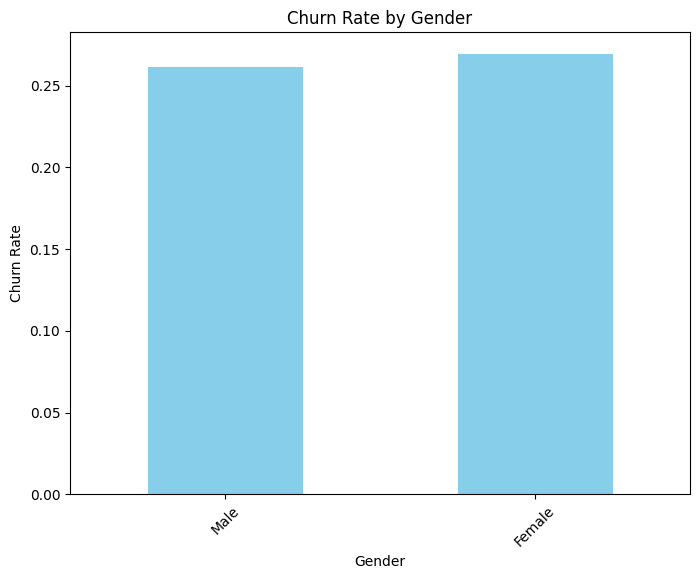

In [91]:
gender_labels = {1: "Female", 0: "Male"}

gender_churn_rate.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.xticks(ticks=[0,1], labels=[gender_labels[0], gender_labels[1]], rotation=45)
plt.show()

In [84]:
tenure_churn_rate = data.groupby('tenure_group')['Churn'].mean()

/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/825807941.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn_rate = data.groupby('tenure_group')['Churn'].mean()


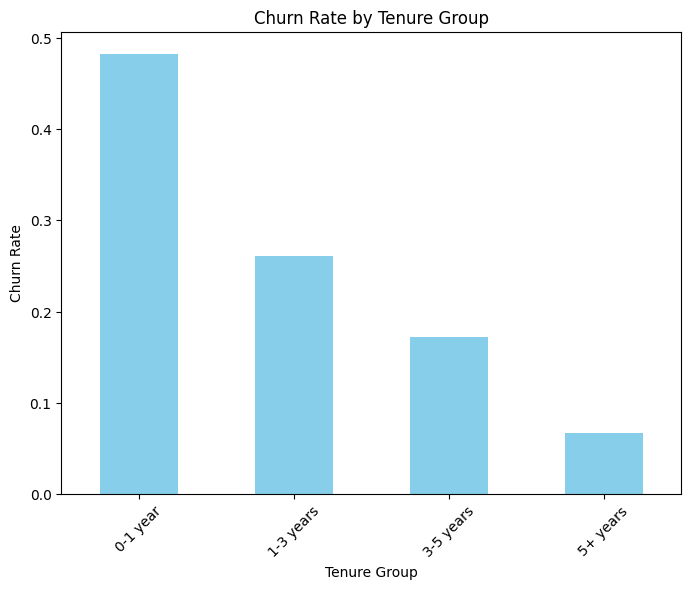

In [85]:
tenure_churn_rate.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title("Churn Rate by Tenure Group")
plt.xlabel("Tenure Group")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.show()

In [29]:
X = data.drop(["Churn", 'customerID'], axis=1)
y = data['Churn']
Z = pd.concat([X,y], axis=1)

In [30]:
print(y.value_counts(normalize=True))

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


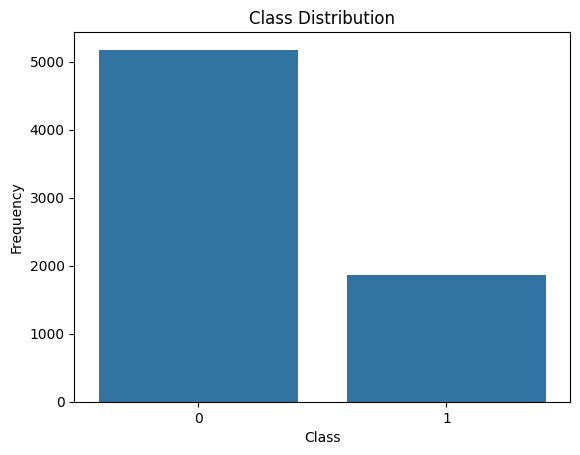

In [31]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [32]:
tenure_mapping = {
    '0-1 year': 1,
    '1-3 years': 2,
    '3-5 years': 3,
    '5+ years': 4
}

X['tenure_group'] = X['tenure_group'].map(tenure_mapping)

In [33]:
print(X['tenure'].unique())
print(X['tenure_group'].unique())

[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
[1, 2, 3, 4]
Categories (4, int64): [1 < 2 < 3 < 4]


In [34]:
X = X.replace(r'^\s*$', np.nan, regex=True)

print(X['TotalCharges'].isnull().sum())

numeric_cols = X.select_dtypes(include=['number']).columns
for col in numeric_cols:
    mean_value = X[col].mean()
    X[col].fillna(mean_value, inplace=True)

total_charges_mean = X['TotalCharges'].astype(float).mean()
X['TotalCharges'].fillna(total_charges_mean, inplace=True)
X['TotalCharges'] = X['TotalCharges'].astype(float)

11


/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/3408675749.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_value, inplace=True)
/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/3408675749.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [35]:
adj_X = X.drop(['InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 
                   'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service',
                   'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes'], axis=1)

In [36]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
adj_X_scaled = scaler.fit_transform(adj_X)

In [37]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
# print(vif_data)


adj_vif_data = pd.DataFrame()
adj_vif_data['Feature'] = adj_X.columns
adj_vif_data['VIF'] = [variance_inflation_factor(adj_X_scaled, i) for i in range(adj_X_scaled.shape[1])]
print(adj_vif_data)

/Users/bengrigsby/.pyenv/versions/3.12.2/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  Feature        VIF
0                                  gender   1.001460
1                           SeniorCitizen   1.148616
2                                 Partner   1.461389
3                              Dependents   1.382227
4                                  tenure  24.884665
5                            PhoneService   1.687663
6                           MultipleLines   1.553947
7                        PaperlessBilling   1.201017
8                          MonthlyCharges   7.868301
9                            TotalCharges  10.211541
10                     TotalSubscriptions   6.650199
11                      Contract_One year   1.585819
12                      Contract_Two year   2.486283
13  PaymentMethod_Credit card (automatic)   1.560187
14         PaymentMethod_Electronic check   1.963654
15             PaymentMethod_Mailed check   1.857232
16                           tenure_group  18.653251


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=30)
adj_X_train, adj_X_test, adj_y_train, adj_y_test = train_test_split(adj_X_scaled, y, test_size=0.2, random_state=30)

In [39]:
rf_model = RandomForestClassifier(
    n_estimators= 200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=30,
    class_weight='balanced'
)

adj_rf_model = RandomForestClassifier(
    n_estimators= 200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=30,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
adj_rf_model.fit(adj_X_train, adj_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=30)

In [40]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END m

In [41]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

adj_y_pred = adj_rf_model.predict(adj_X_test)
adj_y_pred_proba = adj_rf_model.predict_proba(adj_X_test)[:,1]

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.7629524485450674
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1001
           1       0.57      0.70      0.63       408

    accuracy                           0.76      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.78      0.76      0.77      1409

ROC-AUC Score: 0.8386674599909894


In [43]:
adj_accuracy = accuracy_score(adj_y_test, adj_y_pred)
print(f"Accuracy: {adj_accuracy}")
print(f"Classification Report:\n {classification_report(adj_y_test, adj_y_pred)}")
adj_roc_auc = roc_auc_score(adj_y_test, adj_y_pred_proba)
print(f"ROC-AUC Score: {adj_roc_auc}")

Accuracy: 0.765791341376863
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.83      1001
           1       0.58      0.73      0.64       408

    accuracy                           0.77      1409
   macro avg       0.73      0.75      0.73      1409
weighted avg       0.79      0.77      0.77      1409

ROC-AUC Score: 0.8399823215999687


In [44]:
feature_importance = pd.DataFrame(
    {'importance': rf_model.feature_importances_},
    index = X.columns
)

In [45]:
adj_feature_importance = pd.DataFrame(
    {'importance': adj_rf_model.feature_importances_},
    index = adj_X.columns
)

In [46]:
feature_importance.sort_values(by='importance', ascending=False)

,importance
tenure,0.157976
TotalCharges,0.119380
MonthlyCharges,0.091351
tenure_group,0.084916
Contract_Two year,0.083955
InternetService_Fiber optic,0.082587
PaymentMethod_Electronic check,0.048197
OnlineSecurity_Yes,0.031642
Contract_One year,0.028989
TechSupport_Yes,0.024199


In [47]:
adj_feature_importance.sort_values(by='importance', ascending=False)

,importance
MonthlyCharges,0.180530
tenure,0.179754
TotalCharges,0.133704
Contract_Two year,0.131230
tenure_group,0.072400
PaymentMethod_Electronic check,0.070913
TotalSubscriptions,0.059526
Contract_One year,0.054840
PaperlessBilling,0.025383
SeniorCitizen,0.014529


In [48]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.7747595354459647


In [49]:
adj_cv_scores = cross_val_score(adj_rf_model, adj_X_train, adj_y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", adj_cv_scores.mean())

Cross-Validation Accuracy: 0.7681929579307203


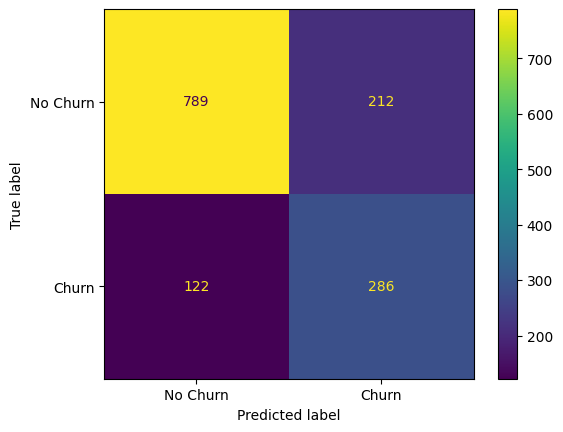

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()


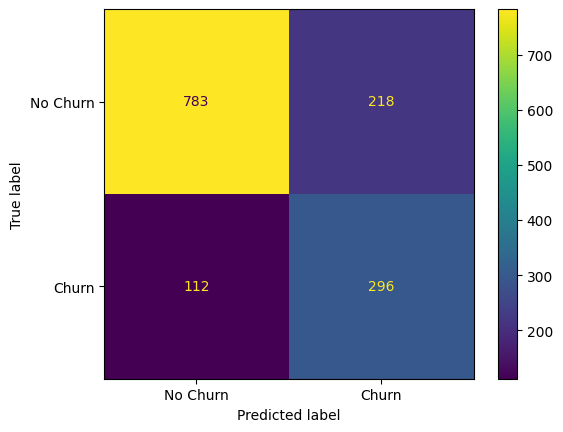

In [51]:
adj_cm = confusion_matrix(adj_y_test, adj_y_pred)
adj_disp = ConfusionMatrixDisplay(confusion_matrix=adj_cm, display_labels=['No Churn', 'Churn'])
adj_disp.plot()
plt.show()


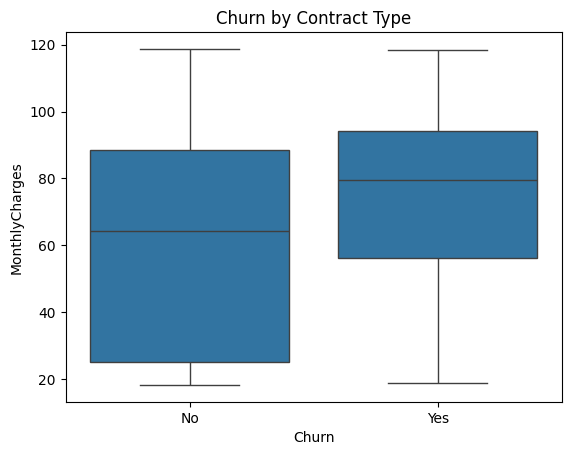

        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
0      5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
1      1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35


In [52]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title("Churn by Contract Type")
plt.xticks(ticks=[0,1], labels=["No", "Yes"])
plt.show()

summary = data.groupby('Churn')['MonthlyCharges'].describe()
print(summary)

In [53]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [54]:
y_pred = knn.predict(X_test)

In [55]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Confusin Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Confusin Matrix
[[865 136]
 [194 214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1001
           1       0.61      0.52      0.56       408

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.76      1409



In [56]:
adj_accuracy = accuracy_score(adj_y_test, adj_y_pred)
print(f"Accuracy: {adj_accuracy:.2f}")

print("Confusin Matrix")
print(confusion_matrix(adj_y_test, adj_y_pred))

print("Classification Report:")
print(classification_report(adj_y_test, adj_y_pred))

Accuracy: 0.77
Confusin Matrix
[[783 218]
 [112 296]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1001
           1       0.58      0.73      0.64       408

    accuracy                           0.77      1409
   macro avg       0.73      0.75      0.73      1409
weighted avg       0.79      0.77      0.77      1409



In [57]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}")

Optimal k: 16


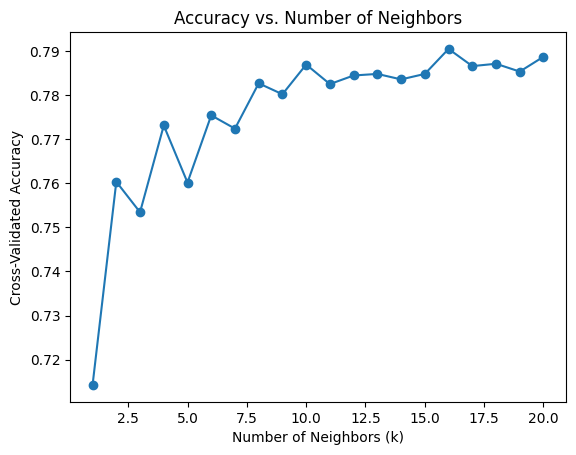

In [58]:
plt.plot(k_values, cv_scores, marker='o')
plt.title("Accuracy vs. Number of Neighbors")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.show()

Removing the 'tenure' column. Despite it being the feature with the highest importance, it is also one of the features that cannot be changed by marketing plans or anything else. 

In [59]:
try:
    X = X.drop('tenure', axis=1)
except:
    print(X.columns)

In [60]:
try:
    adj_X = adj_X.drop('tenure', axis=1)
except:
    print(adj_X.columns)

In [61]:
X = X.replace(r'^\s*$', np.nan, regex=True)

# print(X['TotalCharges'].isnull().sum())

numeric_cols = X.select_dtypes(include=['number']).columns
for col in numeric_cols:
    mean_value = X[col].mean()
    X[col].fillna(mean_value, inplace=True)

total_charges_mean = X['TotalCharges'].astype(float).mean()
X['TotalCharges'].fillna(total_charges_mean, inplace=True)
print(X['TotalCharges'].isnull().sum())

0


/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/979525992.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_value, inplace=True)
/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/979525992.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [62]:
adj_X = adj_X.replace(r'^\s*$', np.nan, regex=True)

# print(X['TotalCharges'].isnull().sum())

numeric_cols = adj_X.select_dtypes(include=['number']).columns
for col in numeric_cols:
    mean_value = adj_X[col].mean()
    adj_X[col].fillna(mean_value, inplace=True)

total_charges_mean = adj_X['TotalCharges'].astype(float).mean()
adj_X['TotalCharges'].fillna(total_charges_mean, inplace=True)
print(adj_X['TotalCharges'].isnull().sum())

0


/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/3903016684.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adj_X[col].fillna(mean_value, inplace=True)
/var/folders/bz/m9n4tlrx3jd3br1gzvg51q_00000gn/T/ipykernel_55549/3903016684.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [63]:
X_scaled = scaler.fit_transform(X)
adj_X_scaled = scaler.fit_transform(adj_X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=30)
adj_X_train, adj_X_test, adj_y_train, adj_y_test = train_test_split(adj_X_scaled, y, test_size=0.2, random_state=30)

In [65]:
rf_model = RandomForestClassifier(
    n_estimators= 200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=30,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=30)

In [66]:
adj_rf_model = RandomForestClassifier(
    n_estimators= 200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=30,
    class_weight='balanced'
)

adj_rf_model.fit(adj_X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=30)

In [67]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

adj_y_pred = adj_rf_model.predict(adj_X_test)
adj_y_pred_proba = adj_rf_model.predict_proba(adj_X_test)[:,1]

In [68]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.758694109297374
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1001
           1       0.57      0.71      0.63       408

    accuracy                           0.76      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.78      0.76      0.77      1409

ROC-AUC Score: 0.8382695735636911


In [69]:
adj_accuracy = accuracy_score(adj_y_test, adj_y_pred)
print(f"Accuracy: {adj_accuracy}")
print(f"Classification Report:\n {classification_report(adj_y_test, adj_y_pred)}")
adj_roc_auc = roc_auc_score(adj_y_test, adj_y_pred_proba)
print(f"ROC-AUC Score: {adj_roc_auc}")

Accuracy: 0.7707594038325053
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1001
           1       0.58      0.74      0.65       408

    accuracy                           0.77      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.79      0.77      0.78      1409

ROC-AUC Score: 0.8384103641456583


In [70]:
feature_importance = pd.DataFrame(
    {'importance': rf_model.feature_importances_},
    index = X.columns
)

In [71]:
feature_importance.sort_values(by='importance', ascending=False)

,importance
TotalCharges,0.160535
tenure_group,0.111615
Contract_Two year,0.106844
MonthlyCharges,0.091118
InternetService_Fiber optic,0.084632
PaymentMethod_Electronic check,0.065971
Contract_One year,0.041103
OnlineSecurity_Yes,0.035525
TotalSubscriptions,0.030009
TechSupport_Yes,0.028905


In [72]:
adj_feature_importance = pd.DataFrame(
    {'importance': rf_model.feature_importances_},
    index = X.columns
)

In [73]:
adj_feature_importance.sort_values(by='importance', ascending=False)

,importance
TotalCharges,0.160535
tenure_group,0.111615
Contract_Two year,0.106844
MonthlyCharges,0.091118
InternetService_Fiber optic,0.084632
PaymentMethod_Electronic check,0.065971
Contract_One year,0.041103
OnlineSecurity_Yes,0.035525
TotalSubscriptions,0.030009
TechSupport_Yes,0.028905


Changing tenure from individual values to grouped values 

In [77]:
X_scaled = scaler.fit_transform(X)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=30)

In [79]:
rf_model = RandomForestClassifier(
    n_estimators= 200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=30,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=30)

In [80]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.758694109297374
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1001
           1       0.57      0.71      0.63       408

    accuracy                           0.76      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.78      0.76      0.77      1409

ROC-AUC Score: 0.8382695735636911


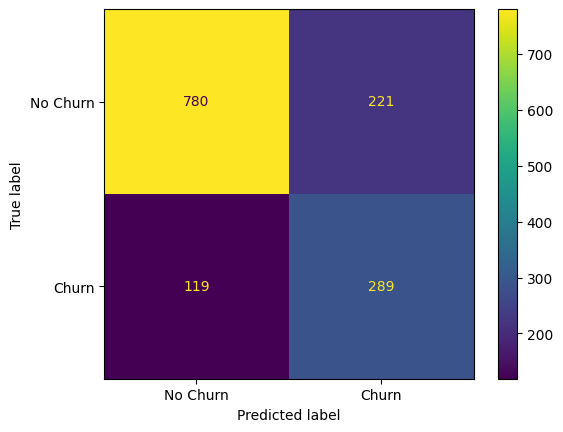

In [83]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()
